In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('ml-bank').getOrCreate()
sdf = spark.read.csv('D:/KULIAHHH/semester 8/BDATA/PROYEK/bank-additional-full.csv', header = True, inferSchema = True)
sdf.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



In [23]:
sdf = sdf.withColumnRenamed("emp.var.rate","emp_var_rate")
sdf = sdf.withColumnRenamed("cons.price.idx","cons_price_idx")
sdf = sdf.withColumnRenamed("cons.conf.idx","cons_conf_idx")
sdf = sdf.withColumnRenamed("nr.employed","nr_employed")


In [24]:
sdf.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



In [8]:
sdf.count()

41188

In [9]:
sdf.toPandas().groupby(['y']).size()

y
no     36548
yes     4640
dtype: int64

In [10]:
numeric_features = [t[0] for t in sdf.dtypes if t[1] == 'int']
sdf.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934057,17,98
duration,41188,258.2850101971448,259.279248836465,0,4918
campaign,41188,2.567592502670681,2.7700135429023245,1,56
pdays,41188,962.4754540157328,186.91090734474085,0,999
previous,41188,0.17296299893172767,0.4949010798392899,0,7


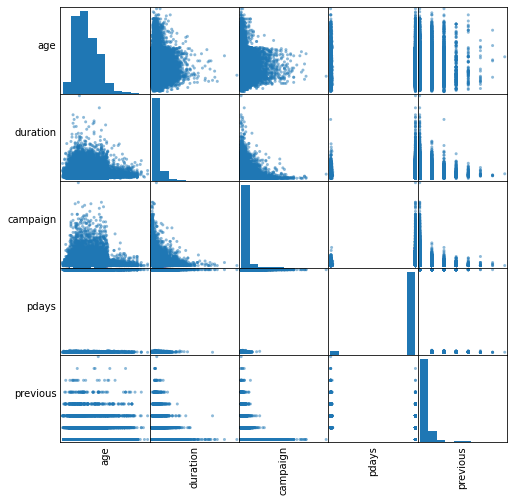

In [13]:
import pandas as pd
numeric_data = sdf.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

day_of_week dan month akan di-drop karena kurang berguna untuk membangun model

In [27]:
sdf = sdf.select(
    'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 
    'contact', 'duration', 'campaign', 'pdays', 'poutcome', 'emp_var_rate',
    'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'
)
cols = sdf.columns
sdf.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



### Prepare Dataset for Machine Learning

In [34]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

stages = []
categoricalColumns = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'
]

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(
        inputCols=[stringIndexer.getOutputCol()], 
        outputCols=[categoricalCol + "classVec"]
    )
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'duration', 'campaign', 'pdays', 'emp_var_rate', 'cons_price_idx', 
               'cons_conf_idx', 'euribor3m', 'nr_employed']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

Pipeline

In [35]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(sdf)
sdf = pipelineModel.transform(sdf)
selectedCols = ['label', 'features'] + cols
sdf = sdf.select(selectedCols)
sdf.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



In [36]:
pdf = pd.DataFrame(sdf.take(5), columns=sdf.columns)
pdf.iloc[:,0:2]

,label,features
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1,0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [37]:
len(pdf.features[0])

39

Split dataset into train and test set

In [38]:
train, test = sdf.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 28839
Test Dataset Count: 12349


## Logistic Regression Model

In [39]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

We can obtain the coefficients by using LogisticRegressionModel’s attributes.

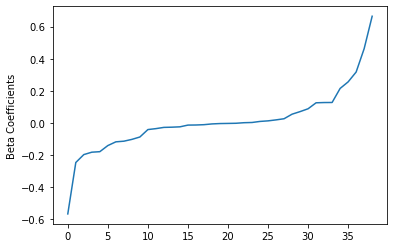

In [41]:
from matplotlib import pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

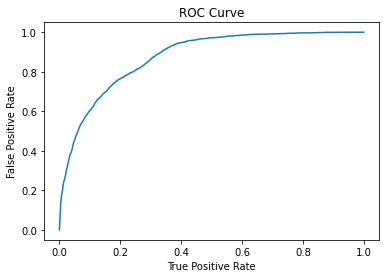

Training set areaUnderROC: 0.8758131450197727


In [42]:
trainingSummary = lrModel.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Precission and Recall

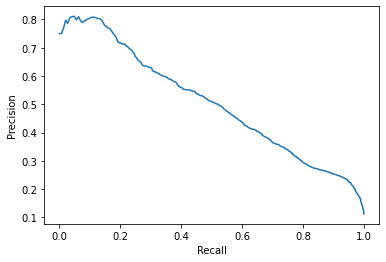

In [43]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Make predictions on the test set

In [45]:
lrPreds = lrModel.transform(test)
lrPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 24|admin.|  0.0|[3.42884977539604...|       0.0|[0.96859409726418...|
| 28|admin.|  0.0|[2.01717298629514...|       0.0|[0.88258837332055...|
| 28|admin.|  0.0|[2.80729796783104...|       0.0|[0.94306892082794...|
| 29|admin.|  0.0|[3.58670838133893...|       0.0|[0.97305671796889...|
| 29|admin.|  0.0|[3.64297233907579...|       0.0|[0.97449319705135...|
| 29|admin.|  0.0|[3.02635641450575...|       0.0|[0.95375071882059...|
| 29|admin.|  0.0|[3.34942948690488...|       0.0|[0.96608614868936...|
| 30|admin.|  0.0|[3.49886413170705...|       0.0|[0.97065543307626...|
| 30|admin.|  0.0|[3.44497801165290...|       0.0|[0.96908102078216...|
| 30|admin.|  0.0|[3.36583277282335...|       0.0|[0.96661949151273...|
+---+------+-----+--------------------+----------+--------------

In [46]:
lrPreds.show()

+-----+--------------------+---+------+-------+-----------------+-------+-------+----+--------+--------+--------+-----+-----------+------------+--------------+-------------+---------+-----------+---+--------------------+--------------------+----------+
|label|            features|age|   job|marital|        education|default|housing|loan| contact|duration|campaign|pdays|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|       rawPrediction|         probability|prediction|
+-----+--------------------+---+------+-------+-----------------+-------+-------+----+--------+--------+--------+-----+-----------+------------+--------------+-------------+---------+-----------+---+--------------------+--------------------+----------+
|  0.0|(39,[0,11,14,21,2...| 24|admin.|married|university.degree|     no|    yes|  no|cellular|     134|       1|  999|nonexistent|         1.4|        93.918|        -42.7|    4.963|     5228.1| no|[3.42884977539604...|[0.96859409726418...|

Evaluate the Logistic Regression model

In [48]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lrEval = BinaryClassificationEvaluator()
print('Test Area Under ROC', lrEval.evaluate(lrPreds))

Test Area Under ROC 0.8718611272767518
